# RHIRL [1]

In [1]:
import numpy as np
import tensorflow as tf
from rhirl import *

from simple_rl.tasks import NavigationMDP
from simple_rl.agents import QLearningAgent
from simple_rl.planning import ValueIteration
from simple_rl.tasks.grid_world.GridWorldStateClass import GridWorldState

from rhirl_plotting import *
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Experiment 5.1

### Navigation MDP

Defined using simple rl framework [3]

In [2]:
np.random.seed(0)
tf.set_random_seed(0)
nvmdp = NavigationMDP(width=7, 
                        height=7,
                        goal_locs=[(5,5)],
                        init_loc=(1,1),
                        #manual_obstacles=[(2,2), (3,2), (4,2), (5,2), (6,2)],
                        rand_init=True,
                        cell_types=["empty", "yellow", "red", "green", "purple"],
                        cell_type_rewards=[0, 0, -10, -10, -10],
                        goal_reward=1.,
                        slip_prob=0.00,
                        step_cost=0.00, vacancy_prob=.8,
                        gamma=.99)

value_iter = ValueIteration(nvmdp, sample_rate=1)
_ = value_iter.run_vi()

### Training Data: 
Set of trajectories D = $\{\tau_0, \tau_1, ..., \tau_N\}$  where  $\tau = [(s_0,a_0), (s_1,a_1), ..., (s_T,a_T)]$

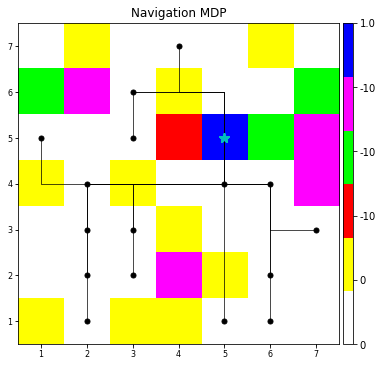

In [3]:
np.random.seed(0)
N_tau = 16 #nvmdp.num_empty_states
D_traj_states, D_traj_actions = nvmdp.sample_data(n_trajectory=N_tau, 
                                                    init_states=[], #GridWorldState(1,7)],
                                                    init_repetition=False, 
                                                    policy=value_iter.policy)
nvmdp.visualize_grid(trajectories=D_traj_states, show_rewards_cbar=True)

In [4]:
gamma = 0.9999
nA = len(nvmdp.actions)
H = 4
phi = nvmdp.feature_long_at_state
phi_loc = nvmdp.feature_long_at_loc

transition_fn = nvmdp.transition_func
actions = nvmdp.actions
phi_s_dim = len(phi(nvmdp.get_init_state()))

SFT, heap_size = get_training_data(D_traj_states, phi, transition_fn, actions, H)
g1, saver = build_rhirl_graph(heap_size, nA, phi_s_dim, gamma, H)
len(g1.get_operations())

436

In [5]:
def compute_full_SFT(nvmdp, phi, h):
    SFT_full = {}
    for row in range(nvmdp.height):
        for col in range(nvmdp.width):
            x, y = nvmdp._rowcol_to_xy(row, col)
            state = GridWorldState(x, y)
            SFT_full[state] = get_FLH(state, phi, nvmdp.transition_func, nvmdp.actions, h)[0]
    return SFT_full
SFT_full = compute_full_SFT(nvmdp, phi, H)

### Check gradients
Try to overfit the model by maximizing a Pi(s_0, a_0)

([<matplotlib.lines.Line2D at 0x119a56160>],
 Text(0.5,1,'p(s_0,a)'),
 Text(0.5,0,'iter'),
 Text(0,0.5,'P'))

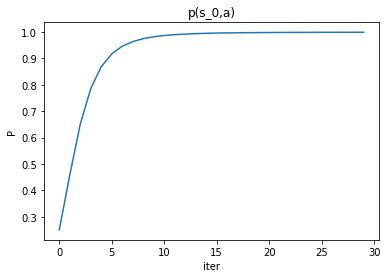

In [6]:
t_idx, s_idx = 0, 0
s, a = D_traj_states[t_idx][s_idx], D_traj_actions[t_idx][s_idx]
w_init = np.zeros((phi_s_dim, 1)).astype(np.float32) # Babes 2014 suggest to initialize w with 0s 
#np.random.uniform(0, 0.1, (phi_s_dim, 1)).astype(np.float32)

with tf.Session(graph=g1) as sess:
    
    sess.run(tf.global_variables_initializer(), feed_dict={"w_init:0": w_init})
    writer = tf.summary.FileWriter('/var/tmp/rhirl/graphs', sess.graph)
    feed_dict = {"state_feature_tree:0": SFT[s], 
                 "action_idx:0": a,
                 "learning_rate:0": 0.1,
                 "pi_init:0": np.zeros((heap_size, nA), np.float32)}
    
    p_vals = []
    for i in range(30):
        pi, v, w, grad, ugrad = sess.run(fetches=["pi_out:0", "v_out:0", "w_r:0", "grad_w_r:0", "update_w_r"], feed_dict=feed_dict)
        p_vals.append(pi[0, a])

writer.close()
plt.plot(p_vals), plt.title("p(s_0,a)"), plt.xlabel("iter"), plt.ylabel("P")

### RHIRL training

Model saved in path: /var/tmp/rhirl_model.ckpt
Total: 2336.130142211914 ms, SFT compute: 1.72290214851721 ms, Epoch time: 116.80549383163452 ms


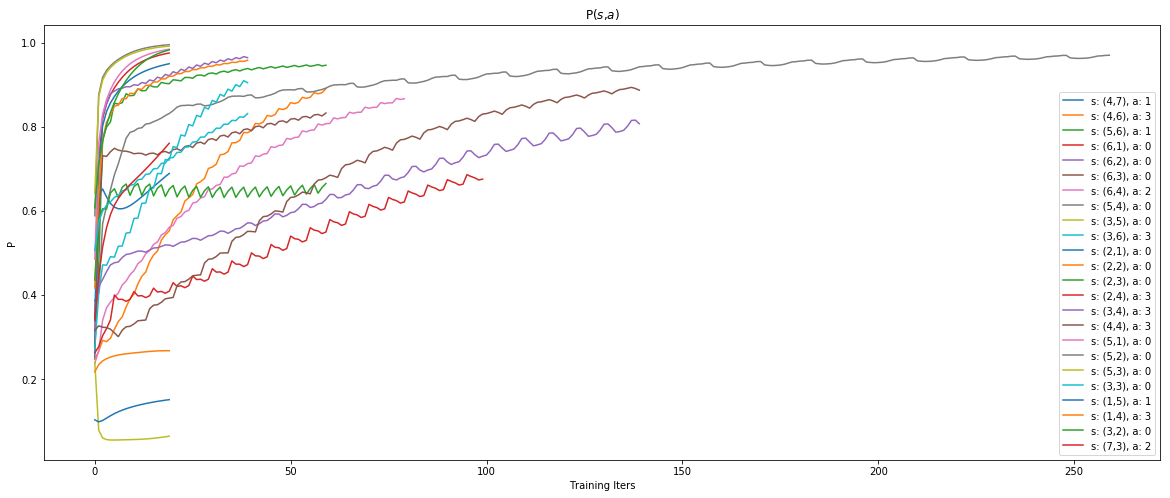

In [7]:
p_vals, w, time_state, time_epoch, time_total = rhirl_train(SFT, phi_s_dim, heap_size, nA, D_traj_states, 
                                                            D_traj_actions, g1, saver, n_epochs=20, lr=0.01, verbose=False)
print("Total: {} ms, SFT compute: {} ms, Epoch time: {} ms".format(time_total, time_state, time_epoch))
plot_p_vals_all_states(p_vals, D_traj_states, D_traj_actions)

In [8]:
def get_in_sample_data(n, D_traj_states, D_traj_actions, repetition=False, init_only=False):
    
    if init_only:
        return [traj[0] for traj in D_traj_states]
        
    if repetition is False:
        unq_states = list(set().union(*[set(traj) for traj in D_traj_states]))
        return [states[idx] for idx in np.random.permutation(len(unq_states))]
    else:
        return [D_traj_states[i][np.random.randint(len(D_traj_states[i]))] for i in np.random.randint(0, len(D_traj_states), n)]

In [9]:
rhc_behavior = {}
rhc_traj_ss, rhc_traj_as = [], []
for init_state in get_in_sample_data(len(D_traj_states), D_traj_states, D_traj_actions, init_only=True):
    states, actions = RHC_rollout(nvmdp, init_state, phi, H, heap_size, w, g1)
    for i in range(len(states)-1):
        rhc_behavior[states[i]] = actions[i]
    rhc_traj_ss.append(states)
    rhc_traj_as.append(actions)

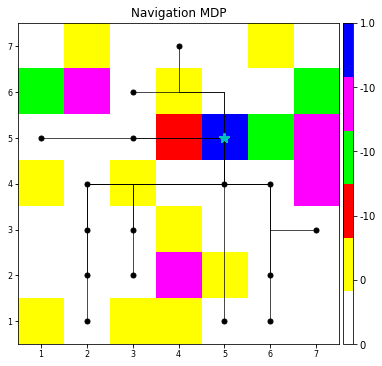

In [10]:
nvmdp.visualize_grid(trajectories=rhc_traj_ss, show_rewards_cbar=True)

In [11]:
def compute_behavior_err(trajectories, policy, expert_policy, verbose=False, count_repeated_errors=False):
    seen_s = defaultdict(lambda: False)
    n_behaviors = 0
    err = 0
    for i in range(len(trajectories)):
        for j in range(len(trajectories[i])-1):
            s = trajectories[i][j]
            a = trajectories[i][j]
            n_behaviors += 1
            expected_a = expert_policy(s)
            
            if a != expected_a and (seen_s[s] is False or count_repeated_errors is True):
                err += 1
                seen_s[s] = True
                if verbose: print("Mistmatch in {}: expert behavior = {}, policy = {}".format(s, expected_a, a))
                    
    return err/float(n_behaviors)

In [12]:
behavior_err = compute_behavior_err(rhc_traj_ss, rhc_behavior, value_iter.policy)
behavior_err

0.3968253968253968

In [13]:
cell_values = compute_cell_values(nvmdp, SFT_full, heap_size, nA, w, g1)
cell_type_rewards = compute_cell_rewards(nvmdp, w[:5], nvmdp.feature_short_at_loc)
cell_rewards = compute_cell_rewards(nvmdp, w, phi_loc)

print("cell, true, obtained")
list(zip(["empty", "yellow", "red", "green", "purple"],[0, 0, -10, -10, -10], 
#          [round(n,2) for n in np.eye(len(nvmdp.cell_types)).dot(w)[:,0]]))
         [round(n,2) for n in np.hstack((np.eye(len(nvmdp.cell_types)), np.zeros((5,5)))).dot(w)[:,0]]))

cell, true, obtained


[('empty', 0, 0.04),
 ('yellow', 0, 1.65),
 ('red', -10, -4.11),
 ('green', -10, -2.17),
 ('purple', -10, -1.03)]

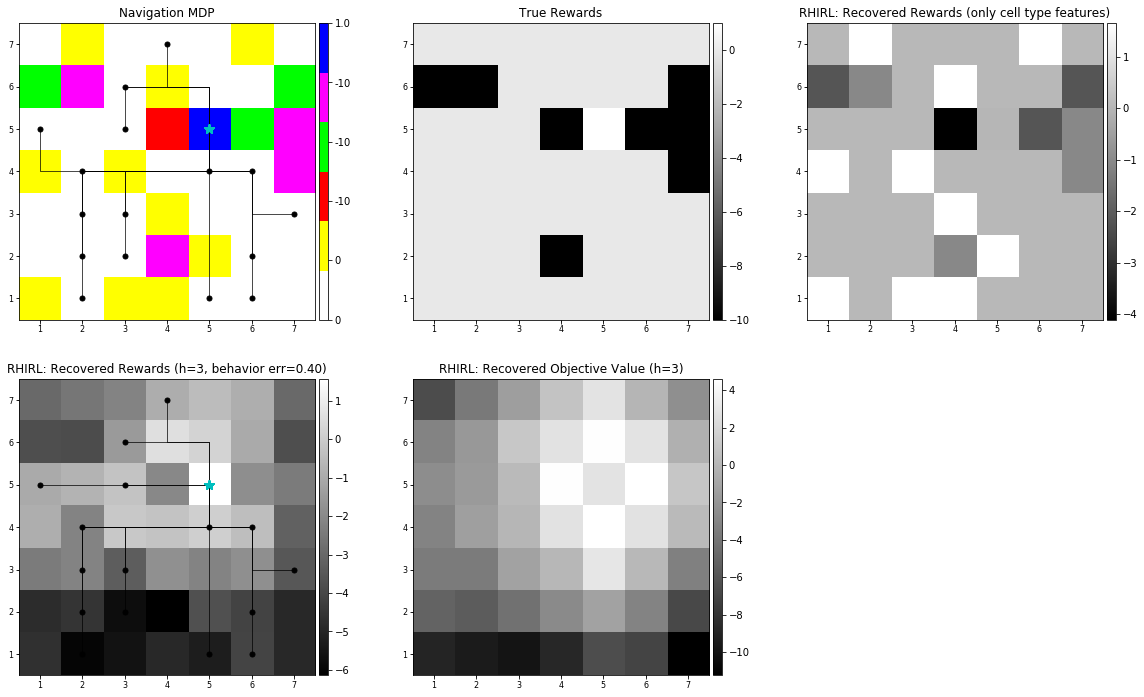

In [14]:
plt.figure(figsize=(20,12))
# cmap=colors.ListedColormap(['white','yellow','red','green','purple', 'blue'])
nvmdp.visualize_grid(nvmdp.cells, trajectories=D_traj_states, 
                     subplot_str="231", new_fig=False, show_rewards_cbar=True)
nvmdp.visualize_grid(nvmdp.cell_rewards, trajectories=None, 
               cmap=plt.cm.gray, subplot_str="232", title="True Rewards", new_fig=False)
nvmdp.visualize_grid(cell_type_rewards, trajectories=None, 
               cmap=plt.cm.gray, subplot_str="233", new_fig=False, title="RHIRL: Recovered Rewards (only cell type features)")
nvmdp.visualize_grid(cell_rewards, trajectories=rhc_traj_ss, 
               cmap=plt.cm.gray, subplot_str="234", new_fig=False, title="RHIRL: Recovered Rewards (h={}, behavior err={:.2f})".format(H-1, behavior_err))
nvmdp.visualize_grid(cell_values, trajectories=None, 
               cmap=plt.cm.gray, subplot_str="235", new_fig=False, title="RHIRL: Recovered Objective Value (h={})".format(H-1))

In [15]:
np.round(cell_values, 3)

array([[ -6.504,  -3.687,  -1.457,   0.915,   2.846,  -0.015,  -2.382],
       [ -3.108,  -1.8  ,   1.109,   2.787,   4.506,   2.816,  -0.295],
       [ -2.486,  -1.655,   0.283,   4.52 ,   2.843,   4.605,   1.077],
       [ -3.09 ,  -1.346,   0.069,   2.761,   4.572,   2.793,   0.303],
       [ -3.577,  -3.602,  -1.195,   0.141,   3.021,   0.157,  -3.299],
       [ -5.065,  -5.493,  -4.23 ,  -2.669,  -1.199,  -3.06 ,  -6.724],
       [ -8.995,  -9.563,  -9.97 ,  -8.767,  -6.465,  -7.009, -11.241]],
      dtype=float32)

In [16]:
np.round(cell_rewards, 3)

array([[-2.959, -2.579, -2.174, -0.932, -0.475, -0.88 , -2.959],
       [-3.788, -3.834, -1.476,  0.603,  0.223, -1.019, -3.788],
       [-1.019, -0.744, -0.234, -2.027,  1.568, -1.848, -2.417],
       [-0.88 , -2.174, -0.095, -0.234,  0.105, -0.406, -3.188],
       [-2.415, -2.14 , -3.329, -1.794, -2.174, -1.835, -3.5  ],
       [-4.812, -4.537, -5.725, -6.144, -3.734, -4.114, -4.93 ],
       [-4.673, -5.966, -5.587, -4.888, -5.268, -4.08 , -4.896]],
      dtype=float32)